# Deconvoling Gaia errors with Normalizing Flow


#===================================================================================
INFO: created directory: ../../results/h277.NormFlow.Couplings_RQS.2024.01.30_20h14
#===================================================================================
+---------------------+--------------------------------------------------------------------------------------------------------+
| Parameters          | Values                                                                                                 |
+---------------------+--------------------------------------------------------------------------------------------------------+
| DATA                | h277                                                                                                   |
| dataset             | ['../../data/gaia/data.angle_340.smeared_00.npy', '../../data/gaia/data.angle_340.smeared_00.cov.npy'] |
| features            | ['x', 'y', 'z', 'vx', 'vy', 'vz']                                            

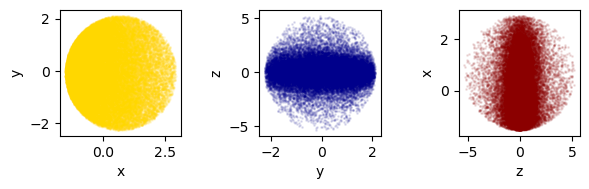

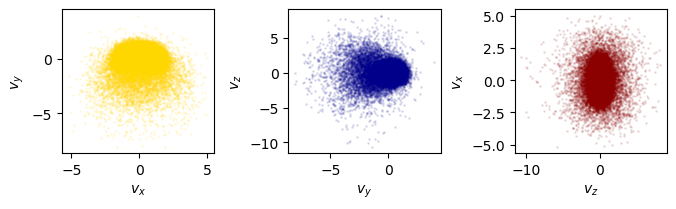

In [19]:
import matplotlib.pyplot as plt 

from deconvolution.trainer.trainer import Trainer
from deconvolution.configs.gaia_configs import Deconvolve_Gaia_Couplings_RQS_NormFlow as Configs

configs = Configs(DATA = 'h277',
                  FEATURES = ['x', 'y', 'z', 'vx', 'vy', 'vz'],
                  DATA_SPLIT_FRACS = [0.8, 0.2, 0.0],
                  PREPROCESS=['unit_ball_transform', 'standardize'],
                  BATCH_SIZE = 2048,
                  EPOCHS = 1000,
                  LR = 1e-4,
                  NUM_BLOCKS = 2,
                  MASK = 'mid-split',
                  NUM_BINS = 20,
                  TAIL_BOUND = 10, 
                  DIM_HIDDEN = 128,
                  NUM_TRANSFORMS = 5,
                  NUM_WORKERS = 8,
                  PIN_MEMORY = True,
                  DEVICE = 'cpu'
                  )
#...set working directory for results:

configs.set_workdir(path='../../results', save_config=True)

from deconvolution.datamodules.gaia.datasets import GaiaDataset
from deconvolution.datamodules.gaia.dataloader import GaiaDataLoader 

gaia = GaiaDataset(configs)
dataloader = GaiaDataLoader (gaia, configs)

#...phase space plots

coord = ['x', 'y', 'z']
color=['gold', 'darkblue', 'darkred']
fig, ax = plt.subplots(1, 3, figsize=(6, 2))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].scatter(gaia.target_preprocess[:50000, i], gaia.target_preprocess[:50000, j], s=1, alpha=0.1, c=color[i])
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()

coord = [r'$v_x$', r'$v_y$', r'$v_z$']
color=['gold', 'darkblue', 'darkred']
fig, ax = plt.subplots(1, 3, figsize=(7, 2.2))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].scatter(gaia.target_preprocess[:50000, i+3], gaia.target_preprocess[:50000, j+3], s=1, alpha=0.1, c=color[i])
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()

In [20]:
from deconvolution.datamodules.gaia.datasets import GaiaDataset 
from deconvolution.datamodules.gaia.dataloader import GaiaDataLoader 
from deconvolution.models.nflow_nets import CouplingsPiecewiseRQS
from deconvolution.dynamics.nf.normflows import NormalizingFlow

gaia = GaiaDataset(configs)

flow = Trainer(dynamics=NormalizingFlow(configs),
               model=CouplingsPiecewiseRQS(configs), 
               dataloader=GaiaDataLoader(gaia, configs), 
               configs=configs)
flow.train()

number of training parameters: 536358
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 128667, validation size: 32166, testing sizes: 1


epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
from deconvolution.pipelines.SamplingPipeline import NormFlowPipeline 
from deconvolution.datamodules.gaia.dataprocess import PostProcessGaiaData 

pipeline = NormFlowPipeline(trained_model=flow, 
                            best_epoch_model=True, 
                            postprocessor=PostProcessGaiaData)

pipeline.generate_samples(num=50000)

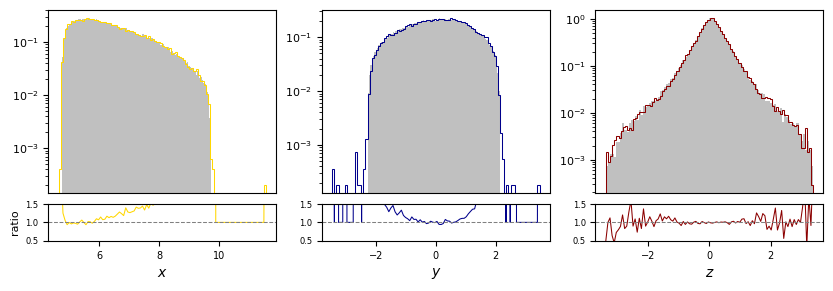

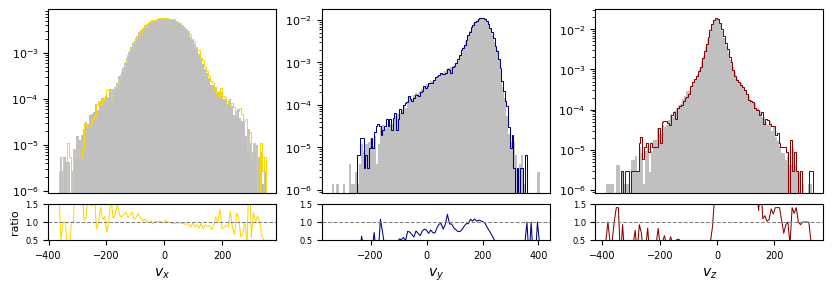

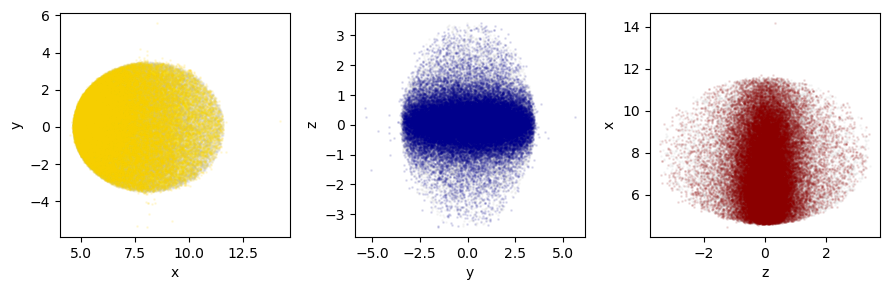

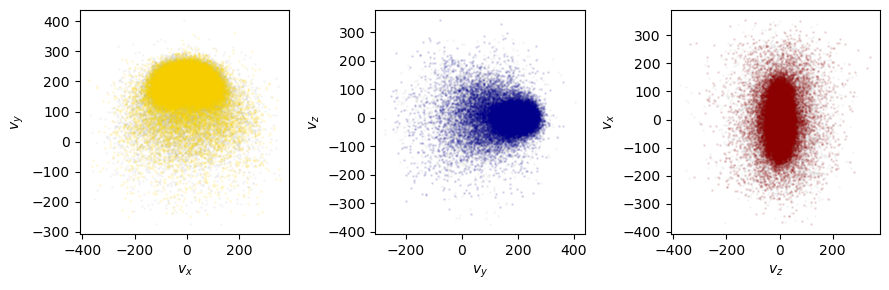

In [22]:
from utils import results_plots

results_plots(gaia.target[..., :3],  
              generated=pipeline.target[..., :3],
              save_dir=configs.workdir,
              features=[r'$x$', r'$y$', r'$z$'], 
              num_particles=100000,
              name_file='gaia_postions')

results_plots(gaia.target[..., 3:], 
              generated=pipeline.target[..., 3:],
              save_dir=configs.workdir,
              features=[r'$v_x$', r'$v_y$', r'$v_z$'], 
              num_particles=100000,
              name_file='gaia_velociites')

coord = ['x', 'y', 'z']
color=['gold', 'darkblue', 'darkred']
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].scatter(gaia.target[:50000, i], gaia.target[:50000, j], s=1, alpha=0.1, c='silver')
    ax[i].scatter(pipeline.target[:50000, i], pipeline.target[:50000, j], s=1, alpha=0.1, c=color[i])
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()

coord = [r'$v_x$', r'$v_y$', r'$v_z$']
color=['gold', 'darkblue', 'darkred']
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].scatter(gaia.target[:50000, i+3], gaia.target[:50000, j+3], s=1, alpha=0.1, c='silver')
    ax[i].scatter(pipeline.target[:50000, i+3], pipeline.target[:50000, j+3], s=1, alpha=0.1, c=color[i])
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()
